<a href="https://colab.research.google.com/github/arestrada/nlp-group3-assignment/blob/main/MSIN0221_Group_3_Notebook_Phase_1_(Data_Preprocessing%2C_EDA%2C_and_Basic_Sentiment_Analysis).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset and package loading

In [1]:
# Mount Google Drive to save datasets permanently
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Install dependencies
!pip install datasets
!pip install pandas numpy beautifulsoup4 spacy emoji contractions ekphrasis textblob
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [3]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 106.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
# Import libraries
import pandas as pd
import numpy as np
import re
import unicodedata
import contractions
import os
from bs4 import BeautifulSoup
import spacy
import emoji
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from textblob import TextBlob
from datasets import load_dataset
from datasets import Dataset as Ds
from datetime import datetime
from collections import defaultdict
from collections import Counter
import pyarrow as pa # To replace Pandas for handling large dataframes
import pyarrow.compute as pc # To replace Pandas for performing Pandas-like operations within the large-sized dataframe
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import random
from IPython.display import display
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
import ast
import warnings
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler # Add mixed precision training imports
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, accuracy_score, f1_score,
    precision_recall_fscore_support, confusion_matrix
    )
import time
import requests
import zipfile
import io

In [5]:
try:
    from transformers import (
        DistilBertTokenizer, DistilBertModel,
        BertTokenizer, BertModel,  # Replace RobertaTokenizer, RobertaModel
        AdamW, get_linear_schedule_with_warmup
    )
except ImportError:
    # If AdamW can't be imported from transformers directly, try alternative imports
    from transformers import (
        DistilBertTokenizer, DistilBertModel,
        BertTokenizer, BertModel,  # Replace RobertaTokenizer, RobertaModel
        get_linear_schedule_with_warmup
    )
    try:
        # Try importing from transformers.optimization (newer versions)
        from transformers.optimization import AdamW
    except ImportError:
        # Fall back to PyTorch's implementation
        from torch.optim import AdamW
        print("Using PyTorch's AdamW implementation instead of transformers'")

# Download necessary NLTK resources
nltk.download('vader_lexicon')
nltk.download('punkt')

Using PyTorch's AdamW implementation instead of transformers'


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
# Handle gensim import - attempt import but provide fallback if it fails
try:
    from gensim.models import KeyedVectors
    GENSIM_AVAILABLE = True
except (ImportError, ValueError) as e:
    print(f"Warning: Could not import gensim.models.KeyedVectors: {e}")
    print("Using random embeddings instead of pre-trained word vectors.")
    GENSIM_AVAILABLE = False

# Set seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set parameters for model
EMBEDDING_DIM = 200  # GloVe dimensions: choose from 50, 100, 200, 300
MAX_SEQ_LENGTH = 100
HIDDEN_DIM = 256
BATCH_SIZE = 64
N_EPOCHS = 5
LEARNING_RATE = 1e-3
N_LAYERS = 2
DROPOUT = 0.5

Using random embeddings instead of pre-trained word vectors.
Using device: cuda


In [7]:
# Suppress specific warnings/
warnings.filterwarnings("ignore", message=".*overflowing tokens.*")

## Reviews dataset

In [8]:
# Define file paths in Google Drive
drive_path = "/content/drive/My Drive/"

# Load or download reviews dataset
dataset_reviews = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Electronics", trust_remote_code=True, split="full")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/30.3k [00:00<?, ?B/s]

Amazon-Reviews-2023.py:   0%|          | 0.00/39.6k [00:00<?, ?B/s]

Electronics.jsonl:   0%|          | 0.00/22.6G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

Loading dataset shards:   0%|          | 0/34 [00:00<?, ?it/s]

In [9]:
# Get a glimpse of the dataset
print("Sample data: ", dataset_reviews[0]) # Print the first element to inspect its keys
print("Available keys:", dataset_reviews[0].keys()) # Print all available keys

Sample data:  {'rating': 3.0, 'title': 'Smells like gasoline! Going back!', 'text': 'First & most offensive: they reek of gasoline so if you are sensitive/allergic to petroleum products like I am you will want to pass on these.  Second: the phone adapter is useless as-is. Mine was not drilled far enough to be able to tighten it into place for my iPhone 12 max. It just slipped & slid all over. Stupid me putting the adapter together first without picking up the binoculars to smell them bc I wasted 15 minutes trying to figure out how to put the adapter together bc it does not come with instructions!  I had to come back here to the website which was a total pain. Third: the tripod is also useless. I would not trust the iOS to hold my $1600 phone nor even a Mattel Barbie for that matter. It’s just inefficient for the job imo.  Third: in order to try to give an honest review I did don gloves & eyewear to check the binoculars out.  They seemed average except for mine seemed to be missing abou

In [10]:
# Convert boundaries to Unix time in milliseconds for time-filtering the dataset
start_time = int(datetime(2021, 1, 1).timestamp() * 1000)
end_time = int(datetime(2023, 12, 31, 23, 59, 59).timestamp() * 1000)

In [11]:
# Filter the dataset based on timestamp
filtered_by_time_verified = dataset_reviews.filter(
    lambda x: start_time <= x['timestamp'] <= end_time and x['verified_purchase'] == True
)

print(f"Total reviews from 2021–2023: {len(filtered_by_time_verified)}")

Filter:   0%|          | 0/43886944 [00:00<?, ? examples/s]

Total reviews from 2021–2023: 11029065


In [12]:
# Convert the Hugging Face dataset into a PyArrow table
reviews_21_23 = filtered_by_time_verified.data.table

In [13]:
# Drop unnecessary columns
columns_to_drop_reviews = ["images", "asin", "user_id", "helpful_vote", "verified_purchase", "title"]
reviews_cleaned = reviews_21_23.drop(columns=columns_to_drop_reviews)

## Metadata dataset

In [14]:
# Define file paths in Google Drive
drive_path = "/content/drive/My Drive/"

# Load or download the metadata dataset
dataset_metadata = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Electronics", trust_remote_code=True, split="full")

meta_Electronics.jsonl:   0%|          | 0.00/5.25G [00:00<?, ?B/s]

Generating full split:   0%|          | 0/1610012 [00:00<?, ? examples/s]

In [15]:
# Get a glimpse of the dataset
print("Sample data: ", dataset_metadata[0]) # Print the first element to inspect its keys
print("Available keys:", dataset_metadata[0].keys()) # Print all available keys

Sample data:  {'main_category': 'All Electronics', 'title': 'FS-1051 FATSHARK TELEPORTER V3 HEADSET', 'average_rating': 3.5, 'rating_number': 6, 'features': [], 'description': ['Teleporter V3 The “Teleporter V3” kit sets a new level of value in the FPV world with Fat Shark renowned performance and quality. The fun of FPV is experienced firsthand through the large screen FPV headset with integrated NexwaveRF receiver technology while simultaneously recording onboard HD footage with the included “PilotHD” camera. The “Teleporter V3” kit comes complete with everything you need to step into the cockpit of your FPV vehicle. We’ve included our powerful 250mW 5.8Ghz transmitter, 25 degree FOV headset (largest QVGA display available), the brand new “PilotHD” camera with live AV out and all the cables, antennas and connectors needed.'], 'price': 'None', 'images': {'hi_res': [None], 'large': ['https://m.media-amazon.com/images/I/41qrX56lsYL._AC_.jpg'], 'thumb': ['https://m.media-amazon.com/image

In [16]:
# Convert the Hugging Face dataset into a PyArrow table
metadata = dataset_metadata.data.table

In [17]:
# Drop unnecessary columns
columns_to_drop_meta = ["images", "videos", "store", "bought_together", "subtitle", "author",
                        "average_rating",	"rating_number",	"features",
                        "description",	"categories",	"details"]
metadata_cleaned = metadata.drop(columns=columns_to_drop_meta)

## Dataset merging

In [18]:
# Perform left join
joined_table = reviews_cleaned.join(
    metadata_cleaned,
    keys="parent_asin",  # Replace with your actual join key
    join_type="left outer",
    right_keys="parent_asin"  # Can be different column name if needed
)

In [19]:
# Group by 'title', then count occurrences
title_counts = joined_table.group_by(["parent_asin", "title"]).aggregate([
    ("title", "count")
])

In [20]:
title_counts_df = title_counts.to_pandas().sort_values(by='title_count', ascending=False)
title_counts_df.head(25)

,parent_asin,title,title_count
327788,B075X8471B,"Fire TV Stick with Alexa Voice Remote, streami...",178239
328140,B07GZFM1ZM,Fire TV Stick 4K streaming device with Alexa V...,140751
327782,B01K8B8YA8,Echo Dot (2nd Generation) - Smart speaker with...,119051
329368,B010BWYDYA,"Fire Tablet with Alexa, 7"" Display, 16 GB, Blu...",103964
327706,B07H65KP63,"Echo Dot (3rd Gen, 2018 release) - Smart speak...",95397
328371,B0791TX5P5,Fire TV Stick streaming device with Alexa buil...,88798
328109,B08XPWDSWW,TOZO T10 Bluetooth 5.3 Wireless Earbuds with W...,72566
328079,B07S764D9V,"Panasonic ErgoFit Wired Earbuds, In-Ear Headph...",55743
327804,B07KTYJ769,"Amazon Smart Plug, for home automation, Works ...",51867
331795,B0BW4PFM58,"OontZ Angle 3 Bluetooth Speaker, Portable Wire...",51568


The table above shows the list of electronics products on Amazon sorted descending by their sales in 2021-2023.

Based on the result, we've decided to focus on four competing airpods/earpods products:
*   TOZO T10 Bluetooth 5.3 Wireless Earbuds
*   Panasonic ErgoFit Wired Earbuds
*   TOZO T6 True Wireless Earbuds Bluetooth 5.3
*   Apple AirPods (2nd Generation) Wireless Earbuds with Lightning Charging Case

In [21]:
# Define the list of parent_asin for each focused product
parent_asin_list = ['B08XPWDSWW', 'B07S764D9V', 'B08XNCHTCY', 'B07PXGQC1Q']

# Create a PyArrow array from the list
parent_asin_array = pa.array(parent_asin_list)

In [22]:
# Filter the joined_table table using the parent_asin_array
filtered_joined_table = joined_table.filter(pc.is_in(joined_table['parent_asin'], value_set=parent_asin_array))

In [23]:
# Transform the PyArrow table into Pandas dataframe
filtered_joined_table_df = filtered_joined_table.to_pandas()

In [24]:
# Get a glimpse of the merged dataset
filtered_joined_table_df.head()

,rating,text,parent_asin,timestamp,main_category,title,price
0,4.0,Great value for the money. The buds go right ...,B07S764D9V,1453858551000,Home Audio & Theater,"Panasonic ErgoFit Wired Earbuds, In-Ear Headph...",13.99
1,4.0,pretty good,B07S764D9V,1566921460133,Home Audio & Theater,"Panasonic ErgoFit Wired Earbuds, In-Ear Headph...",13.99
2,5.0,These earbuds were fine. They were lightweight...,B07S764D9V,1565630121609,Home Audio & Theater,"Panasonic ErgoFit Wired Earbuds, In-Ear Headph...",13.99
3,5.0,Absolutely love these!,B08XNCHTCY,1581987767920,All Electronics,TOZO T6 True Wireless Earbuds Bluetooth 5.3 He...,26.99
4,5.0,These earbuds were well made. The sound was c...,B08XPWDSWW,1589175248846,Home Audio & Theater,TOZO T10 Bluetooth 5.3 Wireless Earbuds with W...,21.99


In [25]:
len(filtered_joined_table_df)

202310

In [26]:
rating_counts_by_title = filtered_joined_table_df.groupby(['title', 'rating'])['rating'].count().reset_index(name='count')
rating_counts_by_title

,title,rating,count
0,Apple AirPods (2nd Generation) Wireless Earbud...,1.0,3112
1,Apple AirPods (2nd Generation) Wireless Earbud...,2.0,906
2,Apple AirPods (2nd Generation) Wireless Earbud...,3.0,1253
3,Apple AirPods (2nd Generation) Wireless Earbud...,4.0,1989
4,Apple AirPods (2nd Generation) Wireless Earbud...,5.0,23278
5,"Panasonic ErgoFit Wired Earbuds, In-Ear Headph...",1.0,4215
6,"Panasonic ErgoFit Wired Earbuds, In-Ear Headph...",2.0,2712
7,"Panasonic ErgoFit Wired Earbuds, In-Ear Headph...",3.0,4006
8,"Panasonic ErgoFit Wired Earbuds, In-Ear Headph...",4.0,8498
9,"Panasonic ErgoFit Wired Earbuds, In-Ear Headph...",5.0,36312


## Random sampling for positive reviews

In [27]:
# Filter for 1-3 star reviews
negative_neutral_reviews = filtered_joined_table_df[filtered_joined_table_df['rating'].isin([1, 2, 3])]

# Filter for 4-5 star reviews
positive_reviews = filtered_joined_table_df[filtered_joined_table_df['rating'].isin([4, 5])]

# Group by title and sample 40% of reviews
sampled_positive_reviews = positive_reviews.groupby('title').apply(lambda x: x.sample(frac=0.4, random_state=42)).reset_index(drop=True)

<ipython-input-27-bb55ae4b9359>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_positive_reviews = positive_reviews.groupby('title').apply(lambda x: x.sample(frac=0.4, random_state=42)).reset_index(drop=True)


In [28]:
# Merge the filtered reviews
sampled_reviews = pd.concat([negative_neutral_reviews, sampled_positive_reviews])

In [29]:
# Display the grouped dataframe by title and rating
sampled_reviews.groupby(['title', 'rating'])['rating'].count().reset_index(name='count')

,title,rating,count
0,Apple AirPods (2nd Generation) Wireless Earbud...,1.0,3112
1,Apple AirPods (2nd Generation) Wireless Earbud...,2.0,906
2,Apple AirPods (2nd Generation) Wireless Earbud...,3.0,1253
3,Apple AirPods (2nd Generation) Wireless Earbud...,4.0,819
4,Apple AirPods (2nd Generation) Wireless Earbud...,5.0,9288
5,"Panasonic ErgoFit Wired Earbuds, In-Ear Headph...",1.0,4215
6,"Panasonic ErgoFit Wired Earbuds, In-Ear Headph...",2.0,2712
7,"Panasonic ErgoFit Wired Earbuds, In-Ear Headph...",3.0,4006
8,"Panasonic ErgoFit Wired Earbuds, In-Ear Headph...",4.0,3476
9,"Panasonic ErgoFit Wired Earbuds, In-Ear Headph...",5.0,14448


# Dataset preprocessing


In [30]:
# Load SpaCy model - disable unnecessary components for speed
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Initialize Ekphrasis for social media text normalization
text_processor = TextPreProcessor(
    # Normalize URLs, emails, percentages, money, phone numbers, and elongated words
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user', 'time', 'date', 'number', 'elongated'],
    # Mark entities
    annotate={"elongated", "hashtag", "allcaps", "repeated"},
    # Segment hashtags
    segmenter="twitter",
    # Use the SocialTokenizer
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
)

class ReviewPreprocessor:
    """
    A comprehensive text preprocessor for Amazon product reviews
    that handles all cleaning and normalization steps in sequence.
    """

    def __init__(self):
        """Initialize the preprocessor with necessary resources"""
        self.nlp = nlp
        self.text_processor = text_processor

    def clean_html(self, text):
        """Remove HTML tags from text"""
        if pd.isna(text) or text == '':
            return ''
        soup = BeautifulSoup(str(text), "html.parser")
        return soup.get_text()

    def remove_special_chars(self, text, keep_dollar=True, keep_percent=True):
        """
        Clean special characters but preserve certain symbols that
        may be relevant for product reviews (prices, percentages)
        """
        if pd.isna(text) or text == '':
            return ''

        # Preserve dollar signs and percentages if needed
        if keep_dollar and keep_percent:
            # Replace special chars except alphanumeric, whitespace, basic punctuation, $ and %
            text = re.sub(r'[^\w\s\.\,\!\?\:\;\(\)\$\%]', ' ', text)
        elif keep_dollar:
            text = re.sub(r'[^\w\s\.\,\!\?\:\;\(\)\$]', ' ', text)
        elif keep_percent:
            text = re.sub(r'[^\w\s\.\,\!\?\:\;\(\)\%]', ' ', text)
        else:
            # Replace all special chars except alphanumeric, whitespace and basic punctuation
            text = re.sub(r'[^\w\s\.\,\!\?\:\;\(\)]', ' ', text)

        # Clean up extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def normalize_whitespace(self, text):
        """Normalize whitespace in text"""
        if pd.isna(text) or text == '':
            return ''
        # Replace multiple spaces, tabs, and newlines with a single space
        text = re.sub(r'\s+', ' ', text)
        return text.strip()

    def normalize_unicode(self, text):
        """Normalize Unicode characters to ASCII where possible"""
        if pd.isna(text) or text == '':
            return ''
        # NFKD decomposition
        text = unicodedata.normalize('NFKD', text)
        # Replace any remaining non-ASCII chars
        text = re.sub(r'[^\x00-\x7F]+', '', text)
        return text

    def expand_contractions(self, text):
        """Expand contractions like don't to do not"""
        if pd.isna(text) or text == '':
            return ''
        return contractions.fix(text)

    def handle_emojis(self, text, replace=True):
        """Handle emojis by either removing or replacing with text descriptions"""
        if pd.isna(text) or text == '':
            return ''
        if replace:
            # Replace emojis with their description
            return emoji.demojize(text, delimiters=(" ", " "))
        else:
            # Remove emojis
            return emoji.replace_emoji(text, '')

    def normalize_text_with_ekphrasis(self, text):
        """Apply Ekphrasis normalization for social media style text"""
        if pd.isna(text) or text == '':
            return ''
        processed = self.text_processor.pre_process_doc(text)
        return " ".join(processed)

    def correct_spelling(self, text, confidence_threshold=0.8):
        """
        Correct spelling using TextBlob, but only with high confidence
        to avoid changing domain-specific terms
        """
        if pd.isna(text) or text == '':
            return ''

        # This is a simplified approach - in practice, you might want to
        # implement a more sophisticated spell-checking process with domain-specific
        # dictionaries for product terminology
        blob = TextBlob(text)

        # A simple heuristic: only correct words shorter than 5 characters
        # This helps avoid "correcting" product names and technical terms
        words = text.split()
        corrected_words = []

        for word in words:
            if len(word) < 5 and word.isalpha():
                word_blob = TextBlob(word)
                corrected = str(word_blob.correct())
                corrected_words.append(corrected)
            else:
                corrected_words.append(word)

        return " ".join(corrected_words)

    def lemmatize_with_spacy(self, text, remove_stopwords=True):
        """
        Tokenize and lemmatize text using spaCy
        Optionally remove stopwords
        """
        if pd.isna(text) or text == '':
            return []

        doc = self.nlp(text)

        if remove_stopwords:
            lemmas = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
        else:
            lemmas = [token.lemma_ for token in doc if not token.is_punct]

        return lemmas

    def preprocess_review(self, text, correct_spelling=False, remove_stopwords=True):
        """
        Apply the full preprocessing pipeline to a review text
        Returns a dictionary with both the processed text and tokens/lemmas
        """
        if pd.isna(text) or text == '':
            return {
                'processed_text': '',
                'lemmas': [],
                'tokens': []
            }

        # Apply each preprocessing step in sequence
        text = self.clean_html(text)
        text = self.remove_special_chars(text)
        text = self.normalize_whitespace(text)
        text = self.normalize_unicode(text)
        text = self.handle_emojis(text, replace=True)
        text = text.lower()  # Convert to lowercase
        text = self.expand_contractions(text)
        text = self.normalize_text_with_ekphrasis(text)

        # Optional spelling correction
        if correct_spelling:
            text = self.correct_spelling(text)

        # Get tokens and lemmas
        doc = self.nlp(text)

        if remove_stopwords:
            tokens = [token.text for token in doc if not token.is_stop and not token.is_punct]
            lemmas = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
        else:
            tokens = [token.text for token in doc if not token.is_punct]
            lemmas = [token.lemma_ for token in doc if not token.is_punct]

        return {
            'processed_text': text,
            'lemmas': lemmas,
            'tokens': tokens
        }

    def process_dataframe(self, df, text_column, correct_spelling=False, remove_stopwords=True):
        """
        Process an entire DataFrame of reviews

        Parameters:
        -----------
        df : pandas.DataFrame
            DataFrame containing the reviews
        text_column : str
            Name of the column containing review text
        correct_spelling : bool
            Whether to apply spelling correction
        remove_stopwords : bool
            Whether to remove stopwords during tokenization/lemmatization

        Returns:
        --------
        pandas.DataFrame
            Original DataFrame with added columns for processed text and tokens
        """
        # Create a copy to avoid modifying the original DataFrame
        result_df = df.copy()

        # Check for missing values
        missing_count = df[text_column].isna().sum()
        if missing_count > 0:
            print(f"Warning: {missing_count} missing values found in '{text_column}' column")

        # Apply preprocessing to each review
        preprocessing_results = df[text_column].apply(
            lambda x: self.preprocess_review(x, correct_spelling, remove_stopwords)
        )

        # Add processed columns to DataFrame
        result_df['processed_text'] = preprocessing_results.apply(lambda x: x['processed_text'])
        result_df['lemmas'] = preprocessing_results.apply(lambda x: x['lemmas'])
        result_df['tokens'] = preprocessing_results.apply(lambda x: x['tokens'])

        # Create a clean text column with lemmas joined for further analysis
        result_df['lemmatized_text'] = result_df['lemmas'].apply(lambda x: ' '.join(x))

        return result_df

/usr/local/lib/python3.11/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading english - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/english/counts_1grams.txt


/usr/local/lib/python3.11/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [31]:
# Initialize the preprocessor
preprocessor = ReviewPreprocessor()

In [33]:
# Run the preprocessor
df = preprocessor.process_dataframe(sampled_reviews, 'text') # For EDA and basic sentiment analysis
df_2 = df.copy() # For aspect-based sentiment analysis

# Display results
print("\nPreprocessed DataFrame (selected columns):")
df.head()

<ipython-input-30-2f8975df1ec7>:31: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  soup = BeautifulSoup(str(text), "html.parser")



Preprocessed DataFrame (selected columns):


,rating,text,parent_asin,timestamp,main_category,title,price,processed_text,lemmas,tokens,lemmatized_text
8,3.0,Bought 2 sets for my grand daughters. I am sur...,B07PXGQC1Q,1577631546284,Apple Products,Apple AirPods (2nd Generation) Wireless Earbud...,99.0,bought <number> sets for my grand daughters . ...,"[buy, <, number, >, set, grand, daughter, sure...","[bought, <, number, >, sets, grand, daughters,...",buy < number > set grand daughter sure like
10,1.0,I will be returning these. They are less than ...,B07S764D9V,1580548782563,Home Audio & Theater,"Panasonic ErgoFit Wired Earbuds, In-Ear Headph...",13.99,i will be returning these . they are less than...,"[return, week, old, turn, use, phone, charge, ...","[returning, week, old, turn, use, phone, charg...",return week old turn use phone charge unreliable
13,3.0,It ok but they kept coming out of my ears,B08XNCHTCY,1615592142819,All Electronics,TOZO T6 True Wireless Earbuds Bluetooth 5.3 He...,26.99,it ok but they kept coming out of my ears,"[ok, keep, come, ear]","[ok, kept, coming, ears]",ok keep come ear
14,1.0,Speakers do not play at the same volume. Who k...,B08XPWDSWW,1627736003470,Home Audio & Theater,TOZO T10 Bluetooth 5.3 Wireless Earbuds with W...,21.99,speakers do not play at the same volume . who ...,"[speaker, play, volume, know, long, come, box,...","[speakers, play, volume, knows, long, come, bo...",speaker play volume know long come box like
15,2.0,Now there's only sound out of one earbud.,B07S764D9V,1407279974000,Home Audio & Theater,"Panasonic ErgoFit Wired Earbuds, In-Ear Headph...",13.99,now there s only sound out of one earbud .,"[s, sound, earbud]","[s, sound, earbud]",s sound earbud


In [34]:
# Show tokens for one review
print("\nTokens for first review:")
print(df['tokens'].iloc[0])

# Count missing values (for demonstration)
missing_values = df.isna().sum()
print("\nMissing values count:")
print(missing_values)


Tokens for first review:
['bought', '<', 'number', '>', 'sets', 'grand', 'daughters', 'sure', 'like']

Missing values count:
rating             0
text               0
parent_asin        0
timestamp          0
main_category      0
title              0
price              0
processed_text     0
lemmas             0
tokens             0
lemmatized_text    0
dtype: int64


In [35]:
# Rename column
df.rename(columns={"title": "product"}, inplace=True)

# Define keyword-based mapping for product names
product_keywords = {
    "Panasonic ErgoFit": "Panasonic ErgoFit",
    "TOZO T6": "Tozo T6",
    "Apple AirPods (2nd Generation)": "Airpods 2nd Generation",
    "TOZO T10": "Tozo T10"
}

# Function to match product names based on keywords
def map_product(title):
    for keyword, short_name in product_keywords.items():
        if keyword.lower() in title.lower():  # Case-insensitive match
            return short_name
    return title  # Keep original if no match found

# Apply function to transform product names
df["product"] = df["product"].apply(map_product)

# Display unique products to verify
print(df["product"].unique())

# Drop NaN value in Text
df.dropna(subset=['text'], inplace=True)

# Check for NaN values in the entire DataFrame
nan_counts = df.isna().sum()
print("NaN counts for each column:\n", nan_counts)

['Airpods 2nd Generation' 'Panasonic ErgoFit' 'Tozo T6' 'Tozo T10']
NaN counts for each column:
 rating             0
text               0
parent_asin        0
timestamp          0
main_category      0
product            0
price              0
processed_text     0
lemmas             0
tokens             0
lemmatized_text    0
dtype: int64


# Exploratory data analysis

## Word Cloud & 2-gram model for each product

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


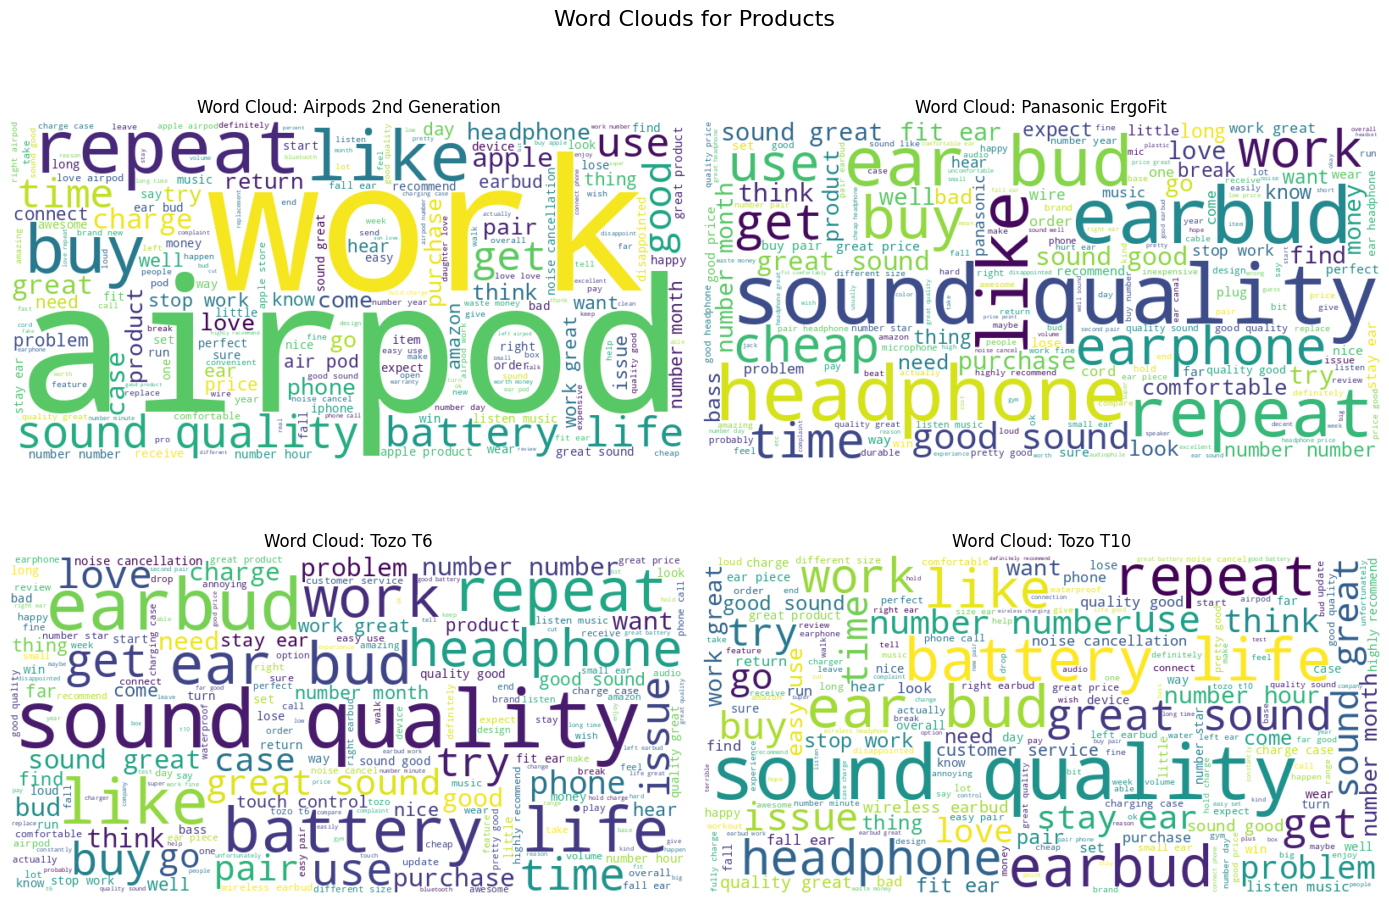

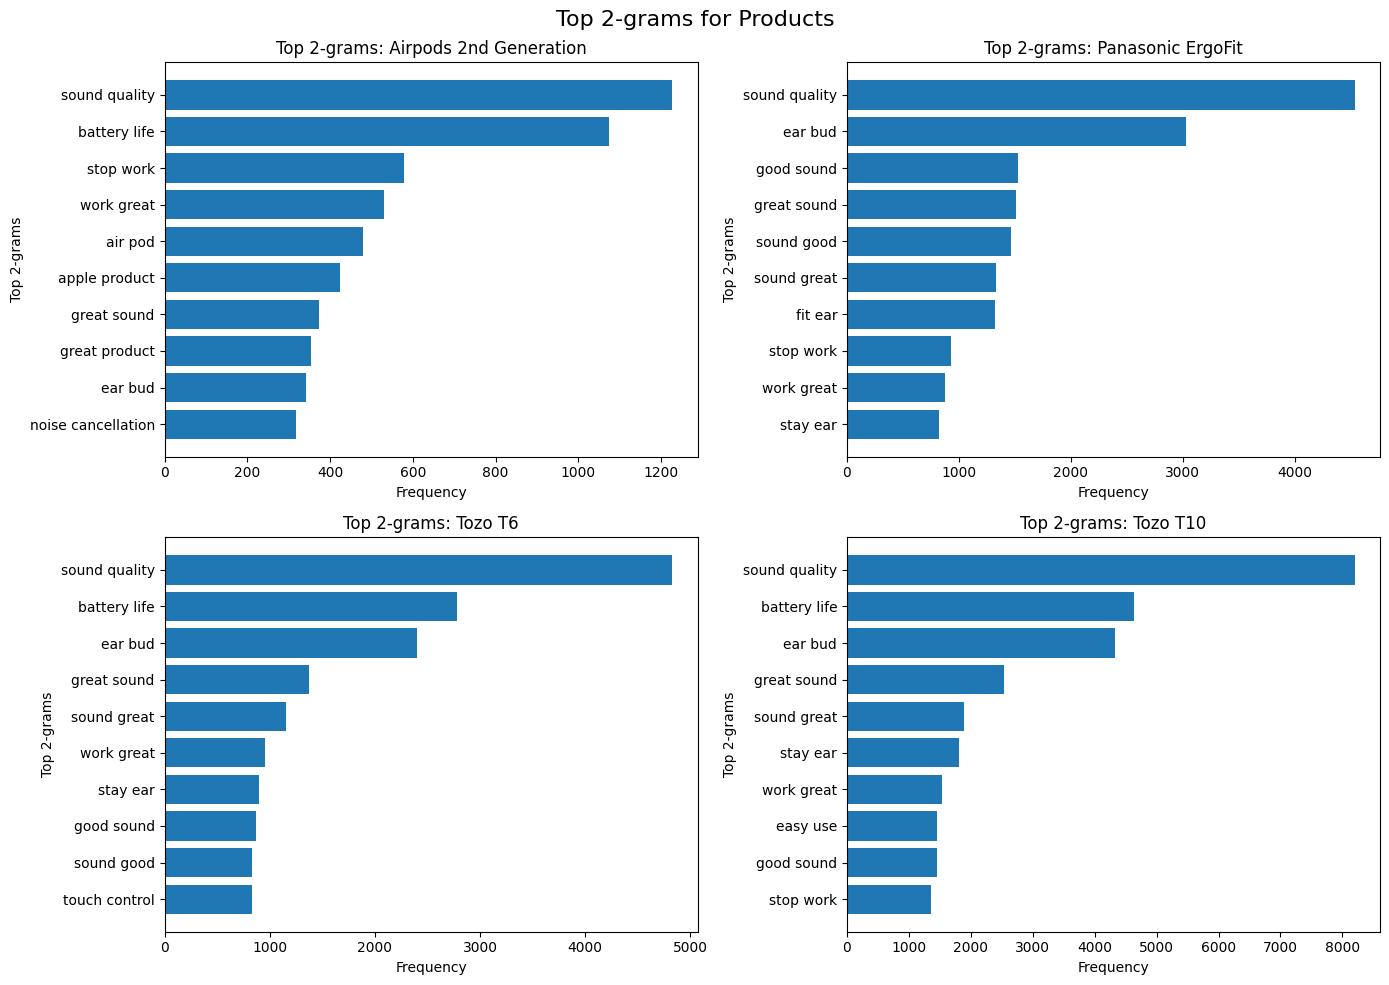

In [36]:
# Ensure necessary NLTK resources are available
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Function to generate word clouds for each product
def generate_wordcloud(df, product, ax):
    text = " ".join(df[df["product"] == product]["lemmatized_text"].dropna().astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords=stop_words).generate(text)

    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(f"Word Cloud: {product}")

# Function to plot top n-grams while filtering out unwanted placeholders
def plot_ngrams(df, product, n, top_n, ax):
    text = " ".join(df[df["product"] == product]["lemmatized_text"].dropna().astype(str))
    tokens = [word for word in text.split() if word not in stop_words]
    n_grams = list(ngrams(tokens, n))

    # Count occurrences of n-grams and remove those containing < or >
    ngram_counts = Counter(n_grams)
    filtered_ngrams = {gram: count for gram, count in ngram_counts.items() if not any("<" in word or ">" in word for word in gram)}

    # Get the top n-grams
    top_ngrams = sorted(filtered_ngrams.items(), key=lambda x: x[1], reverse=True)[:top_n]
    ngram_labels = [" ".join(gram) for gram, _ in top_ngrams]
    ngram_values = [count for _, count in top_ngrams]

    # Plot
    ax.barh(ngram_labels[::-1], ngram_values[::-1])  # Reverse for descending order
    ax.set_xlabel("Frequency")
    ax.set_ylabel(f"Top {n}-grams")
    ax.set_title(f"Top {n}-grams: {product}")

# Extract unique product names
unique_products = df["product"].unique()

# Set up subplots for Word Clouds
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Word Clouds for Products", fontsize=16)
for ax, product in zip(axes.flatten(), unique_products):
    generate_wordcloud(df, product, ax)
plt.tight_layout()
plt.show()

# Set up subplots for bigram analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Top 2-grams for Products", fontsize=16)
for ax, product in zip(axes.flatten(), unique_products):
    plot_ngrams(df, product, n=2, top_n=10, ax=ax)
plt.tight_layout()
plt.show()

## Rating distribution for each product

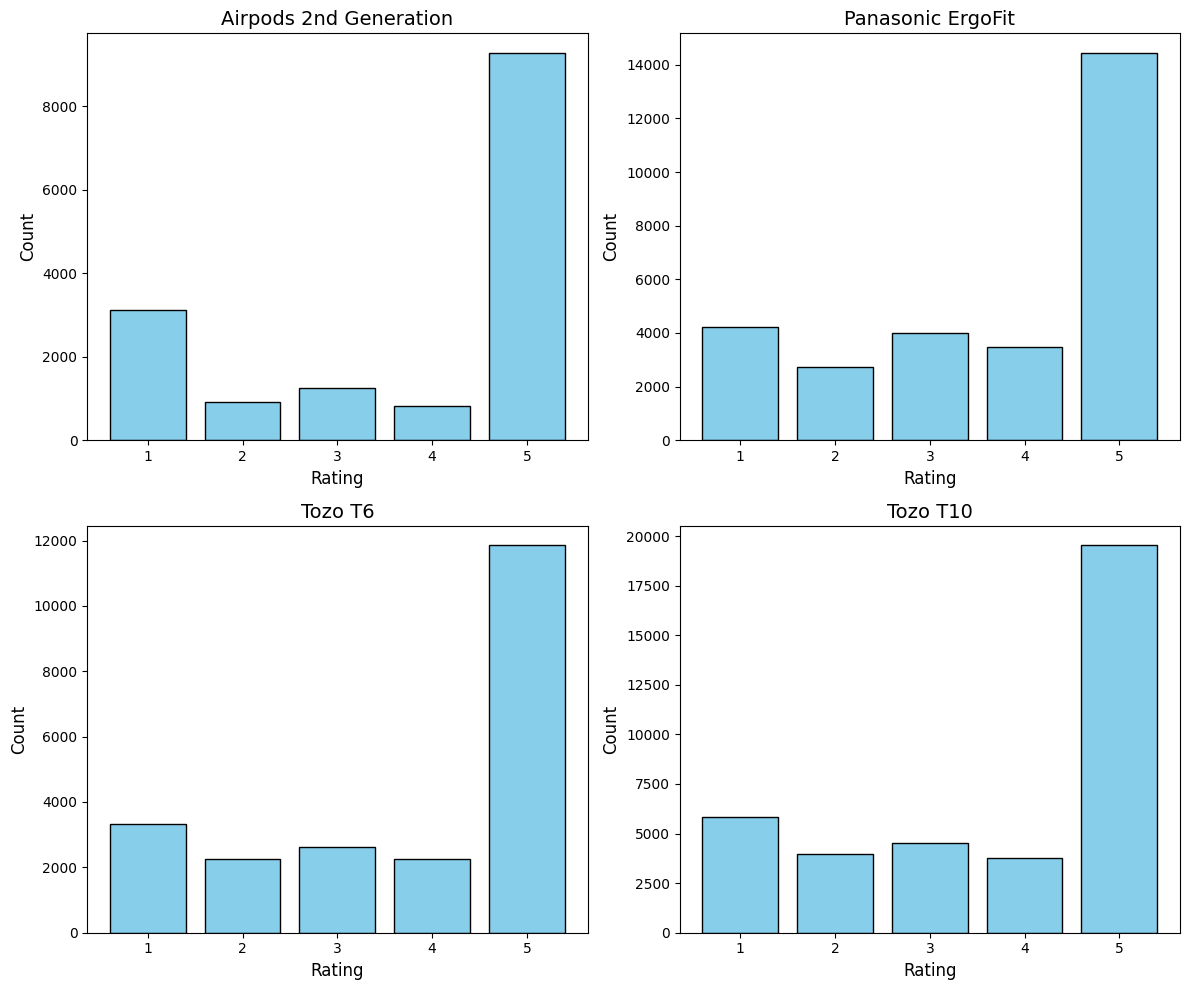

In [37]:
# Get unique products
products = df['product'].unique()

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Adjust number of rows/cols based on products
axes = axes.flatten()  # Flatten the 2D array of axes into a 1D array for easier iteration

# Plot each product's rating distribution
for i, product in enumerate(products):
    # Filter data for the current product
    product_data = df[df['product'] == product]

    # Get rating counts
    rating_counts = product_data['rating'].value_counts().sort_index()

    # Plot on the respective subplot
    axes[i].bar(rating_counts.index, rating_counts.values, color='skyblue', edgecolor='black')
    axes[i].set_title(f"{product}", fontsize=14)
    axes[i].set_xlabel("Rating", fontsize=12)
    axes[i].set_ylabel("Count", fontsize=12)
    axes[i].set_xticks(rating_counts.index)
    axes[i].grid(False)

# Remove any unused subplots (if the number of products is less than 4)
for j in range(len(products), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

## Convert rating into positive, neutral, and negative

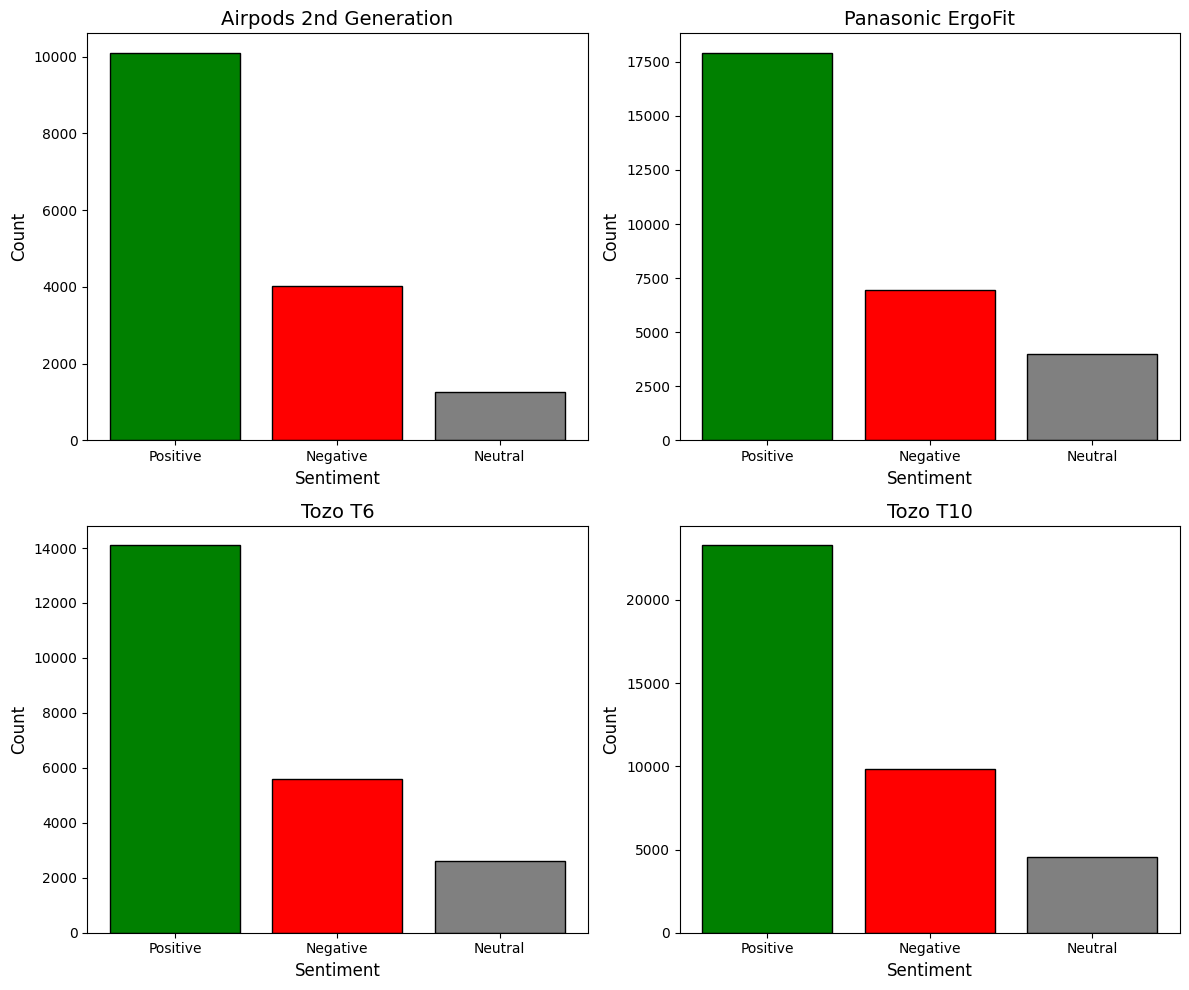

In [38]:
# Define function to map ratings into categories
def aggregate_ratings(rating):
    if rating in [1, 2]:
        return 'Negative'
    elif rating == 3:
        return 'Neutral'
    elif rating in [4, 5]:
        return 'Positive'

# Map ratings to categories
df['rating_category'] = df['rating'].apply(aggregate_ratings)

# Get unique products
products = df['product'].unique()

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Adjust number of rows/cols based on products
axes = axes.flatten()  # Flatten the 2D array of axes into a 1D array for easier iteration

# Plot each product's rating distribution
for i, product in enumerate(products):
    # Filter data for the current product
    product_data = df[df['product'] == product]

    # Get category counts
    category_counts = product_data['rating_category'].value_counts()

    # Plot on the respective subplot
    axes[i].bar(category_counts.index, category_counts.values, color=['green', 'red', 'gray'], edgecolor='black')
    axes[i].set_title(f"{product}", fontsize=14)
    axes[i].set_xlabel("Sentiment", fontsize=12)
    axes[i].set_ylabel("Count", fontsize=12)
    axes[i].grid(False)

# Remove any unused subplots (if the number of products is less than 4)
for j in range(len(products), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

# Basic sentiment analysis

## Removal of neutral

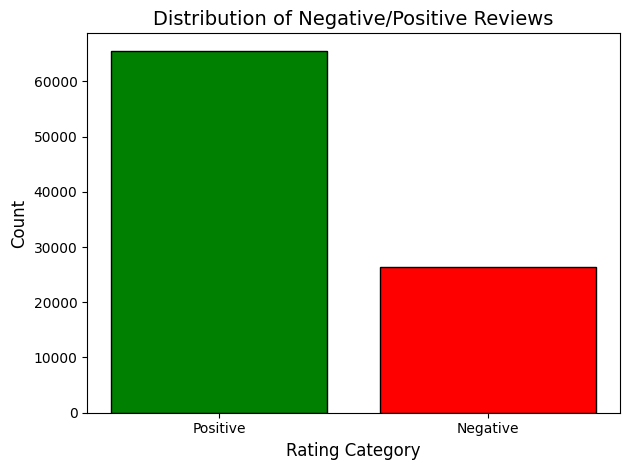

In [39]:
# Only keep Positive/Negative reviews
df = df[df['rating_category'] != 'Neutral']

# Count the distribution of Positive vs. Negative
rating_counts = df['rating_category'].value_counts()

# Create a bar chart
plt.bar(rating_counts.index, rating_counts.values, color=['green','red'], edgecolor='black')
plt.title("Distribution of Negative/Positive Reviews", fontsize=14)
plt.xlabel("Rating Category", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=0)  # Keep the category labels horizontal
plt.grid(False)
plt.tight_layout()
plt.show()

## Stratified sampling

In [40]:
def stratified_sample(df, group_cols, n):
    """
    For each unique combination in group_cols, sample exactly n rows.
    """
    return df.groupby(group_cols, group_keys=False).apply(lambda x: x.sample(n=n, random_state=42))

# Set a fixed sample size per group (e.g., 100)
n_per_group = 1000
balanced_df = stratified_sample(df, ['product', 'rating_category'], n=n_per_group)

# Output stratified sample sizes to check
group_sizes = balanced_df.groupby(['product', 'rating_category']).size()
print("Stratified sample sizes per group:")
print(group_sizes)


Stratified sample sizes per group:
product                 rating_category
Airpods 2nd Generation  Negative           1000
                        Positive           1000
Panasonic ErgoFit       Negative           1000
                        Positive           1000
Tozo T10                Negative           1000
                        Positive           1000
Tozo T6                 Negative           1000
                        Positive           1000
dtype: int64


<ipython-input-40-715ad6ecd395>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols, group_keys=False).apply(lambda x: x.sample(n=n, random_state=42))


## VADER

In [41]:
sid = SentimentIntensityAnalyzer()
def vader_sentiment(review_text):
    score = sid.polarity_scores(review_text)['compound']
    return 'Positive' if score >= 0 else 'Negative'
balanced_df['vader_sentiment'] = balanced_df['text'].apply(vader_sentiment)

## BERT

In [42]:
bert_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    tokenizer="distilbert-base-uncased-finetuned-sst-2-english",
    max_length=512,
    truncation=True,
    device=0  # Use GPU if available
)
def classify_batch_bert(batch):
    results = bert_pipeline(batch["text"])
    sentiments = [ "Positive" if r["label"] == "POSITIVE" else "Negative" for r in results ]
    return {"bert_sentiment": sentiments}
ds_bert = Ds.from_pandas(balanced_df[['text']])
ds_bert = ds_bert.map(classify_batch_bert, batched=True, batch_size=128)
balanced_df["bert_sentiment"] = ds_bert["bert_sentiment"]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


## LLM (Qwen2-0.5-Instruct)

In [43]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed()

device_str = "cuda" if torch.cuda.is_available() else "cpu"
model_llm = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2-0.5B-Instruct",
    torch_dtype="auto",
    device_map="auto" if device_str == "cuda" else None
)
tokenizer_llm = AutoTokenizer.from_pretrained("Qwen/Qwen2-0.5B-Instruct")
def classify_sentence(sentence):
    system_prompt = "You are an expert sentiment classifier."
    user_prompt = (f"Classify the following sentence into one of two classes: 'positive' or 'negative'. "
                   f"Answer with either 'positive' or 'negative' with no additional text.\n\n"
                   f"Sentence: \"{sentence}\"\nLabel:")
    messages = [{"role": "system", "content": system_prompt}, {"role": "user", "content": user_prompt}]
    text = tokenizer_llm.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    model_inputs = tokenizer_llm([text], return_tensors="pt", padding=True, truncation=True).to(device_str)
    generated_ids = model_llm.generate(model_inputs.input_ids, attention_mask=model_inputs.attention_mask, max_new_tokens=5, do_sample=True)
    response = tokenizer_llm.batch_decode(generated_ids[:, model_inputs.input_ids.shape[1]:], skip_special_tokens=True)[0].strip().split()[0].lower()
    return response if response in ["positive", "negative"] else "negative"
balanced_df['llm_sentiment'] = balanced_df['text'].astype(str).apply(classify_sentence)

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

## Visualisation

### Overlay histogram

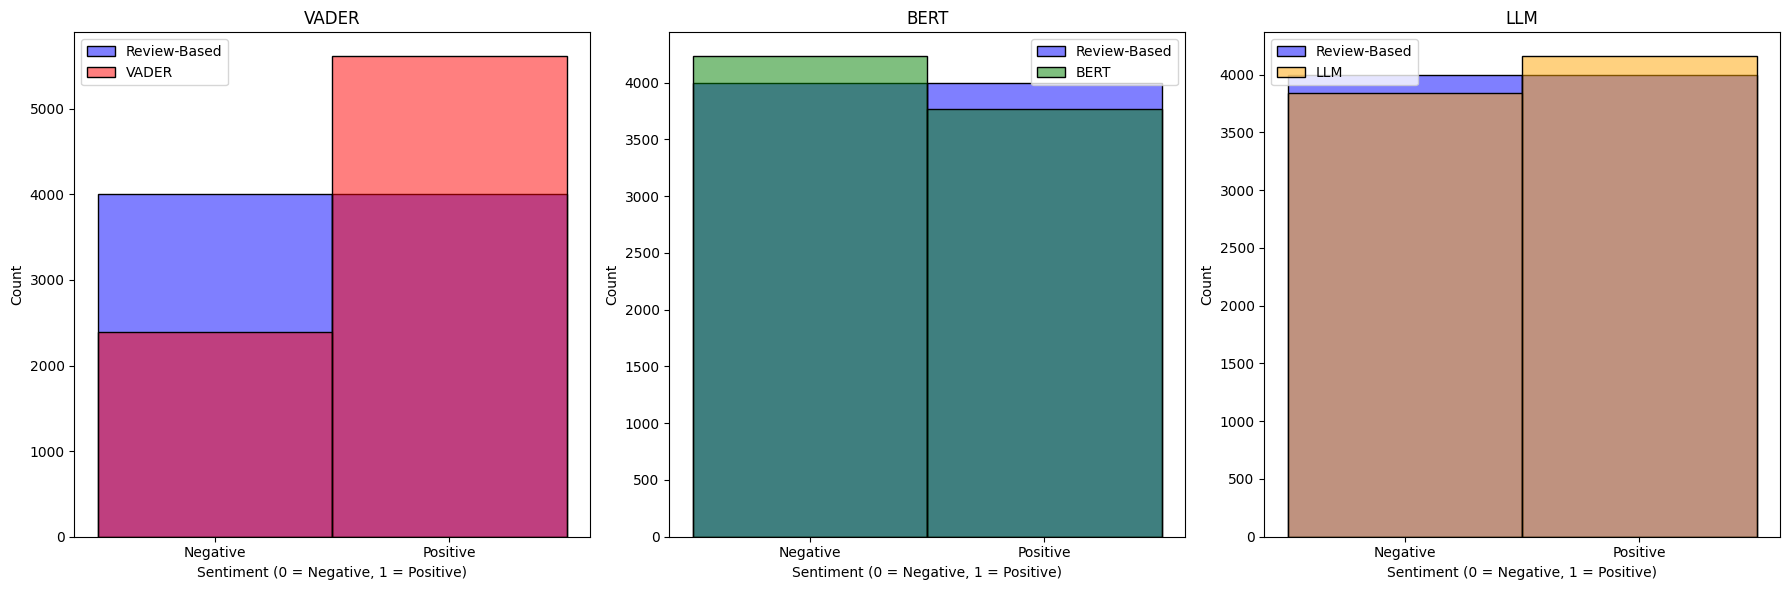

In [44]:
# Numeric mappings for plotting
balanced_df["rating_num"] = balanced_df["rating_category"].map({"Negative": 0, "Positive": 1})
balanced_df["vader_num"]  = balanced_df["vader_sentiment"].map({"Negative": 0, "Positive": 1})
balanced_df["bert_num"]   = balanced_df["bert_sentiment"].map({"Negative": 0, "Positive": 1})

# Normalize LLM predictions to title-case and map to numeric
balanced_df["llm_sentiment"] = balanced_df["llm_sentiment"].str.capitalize()
balanced_df["llm_num"]    = balanced_df["llm_sentiment"].map({"Negative": 0, "Positive": 1})

# Overlay Histograms aggregated across all products
def plot_overlay_histograms_agg():
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns
    models = [("vader_num", "VADER", "red"),
              ("bert_num", "BERT", "green"),
              ("llm_num", "LLM", "orange")]

    for ax, (model_num_col, model_name, color) in zip(axes, models):
        # Plot review-based sentiment and model prediction overlayed
        sns.histplot(balanced_df["rating_num"], color="blue", alpha=0.5,
                     label="Review-Based", discrete=True, ax=ax)
        sns.histplot(balanced_df[model_num_col], color=color, alpha=0.5,
                     label=model_name, discrete=True, ax=ax)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(["Negative", "Positive"])
        ax.set_title(model_name)
        ax.set_xlabel("Sentiment (0 = Negative, 1 = Positive)")
        ax.set_ylabel("Count")
        ax.legend()

    plt.tight_layout()
    plt.show()

# Plot the aggregated overlay histograms for all three models
plot_overlay_histograms_agg()

### Confusion matrix

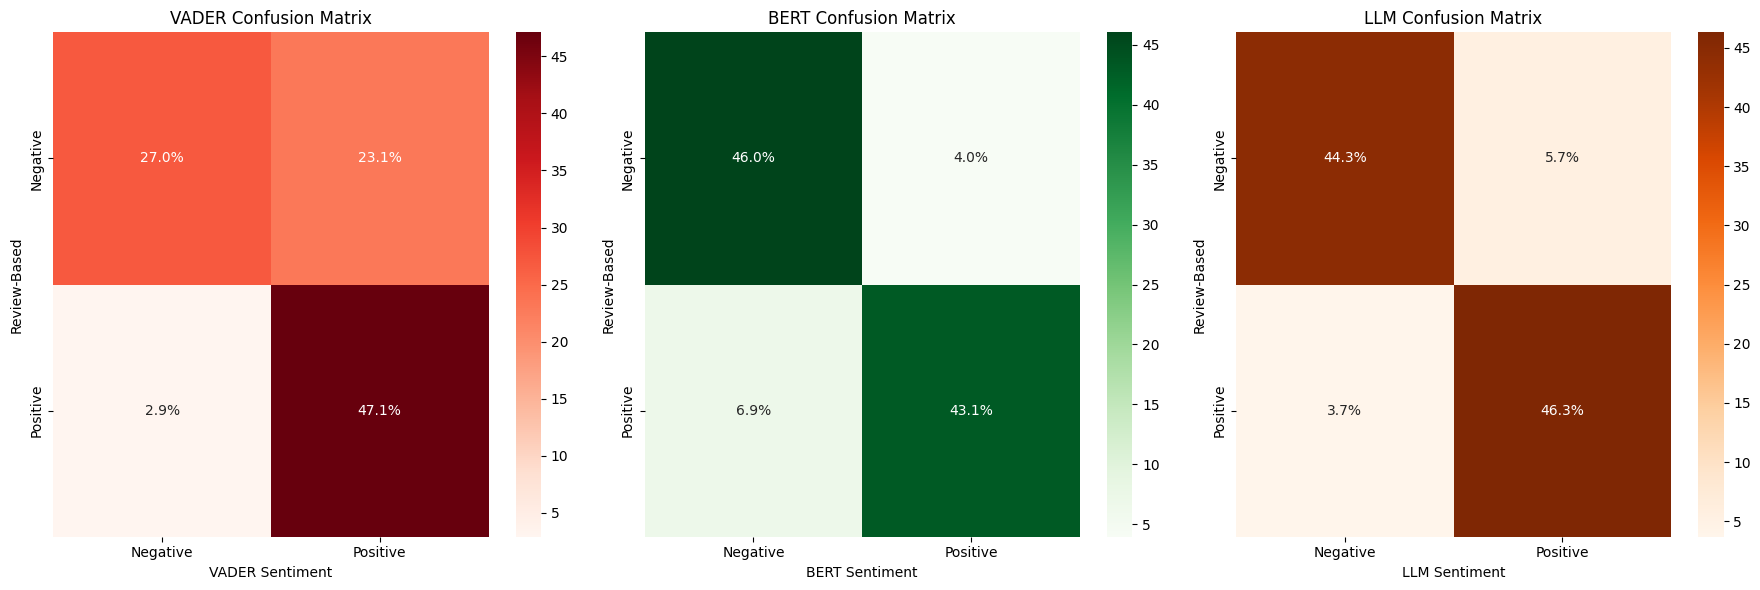

In [45]:
def plot_confusion_matrices_agg():
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns
    models = [("vader_sentiment", "VADER", "Reds"),
              ("bert_sentiment", "BERT", "Greens"),
              ("llm_sentiment", "LLM", "Oranges")]

    for ax, (model_pred_col, model_name, cmap) in zip(axes, models):
        # Compute confusion matrix for the entire dataset
        cm = confusion_matrix(balanced_df["rating_category"],
                              balanced_df[model_pred_col],
                              labels=["Negative", "Positive"])
        cm_pct = (cm.astype("float") / cm.sum()) * 100
        # Prepare annotation labels with percentages
        labels = np.array([["{:.1f}%".format(value) for value in row] for row in cm_pct])

        sns.heatmap(cm_pct, annot=labels, fmt="", cmap=cmap,
                    xticklabels=["Negative", "Positive"],
                    yticklabels=["Negative", "Positive"],
                    ax=ax)
        ax.set_title(f"{model_name} Confusion Matrix")
        ax.set_xlabel(f"{model_name} Sentiment")
        ax.set_ylabel("Review-Based")

    plt.tight_layout()
    plt.show()

plot_confusion_matrices_agg()

### Mismatches pattern

In [46]:
def display_mismatches_agg():
    models = [("vader_sentiment", "VADER"),
              ("bert_sentiment", "BERT"),
              ("llm_sentiment", "LLM")]

    for model_pred_col, model_name in models:
        mismatch = balanced_df[balanced_df["rating_category"] != balanced_df[model_pred_col]]
        print(f"\nMismatch Samples for {model_name} (Total mismatches: {len(mismatch)}):")
        display(mismatch[['product', 'text', 'rating_category', model_pred_col]].head(5))

# Ensure full text display for better visibility
pd.set_option("display.max_colwidth", None)
display_mismatches_agg()


Mismatch Samples for VADER (Total mismatches: 2075):


,product,text,rating_category,vader_sentiment
73418,Airpods 2nd Generation,One of them didn’t work,Negative,Positive
73917,Airpods 2nd Generation,[[VIDEOID:8d8d756e38af88c5359b56c1697442b7]] Battery life to short for price,Negative,Positive
138926,Airpods 2nd Generation,I was under the impression that it was new!!! NOT USED!! Obviously they belong to a Michelle 😒,Negative,Positive
75580,Airpods 2nd Generation,"Apple iPods aren’t connecting! Bought them for our daughter in 2022 for Christmas, it’s now March of 2023 so 3 months they worked. Seems they should work longer with a price tag like that. This is our second set we have purchased and had issues with. Will never order these again. Do better APPLE!",Negative,Positive
75582,Airpods 2nd Generation,Please I need my refund and urgent please this thing is not working,Negative,Positive



Mismatch Samples for BERT (Total mismatches: 865):


,product,text,rating_category,bert_sentiment
107891,Airpods 2nd Generation,The sound quality in general.,Negative,Positive
73923,Airpods 2nd Generation,The right AirPod doesn't work consistently keeps cutting out while the left is fine.,Negative,Positive
134790,Airpods 2nd Generation,Never get a refurbished item again. I purchase July 2019 and now January 2020. Battery doesn’t last and now I can’t hear phone calls. Right side takes forever takes a minute to connect. I brought new AirPods before this one and I loved it!,Negative,Positive
88318,Airpods 2nd Generation,"Unfortunately, I had to request a refund because the AirPods would not connect to any of my devices. I thought that I could save a few bucks by purchasing the AirPods that were used but in good condition as they were supposed to be verified to work but this wasn’t the case. I ended up requesting a refund on the used pair and ordering AirPods that were brand new on the same night. The brand new pair worked great. Fortunately, even if you buy the “used in good condition” ones that are verified by the seller and they do not work the return/refund process was very easy.",Negative,Positive
63409,Airpods 2nd Generation,Only the right ear pod works.,Negative,Positive



Mismatch Samples for LLM (Total mismatches: 749):


,product,text,rating_category,llm_sentiment
138926,Airpods 2nd Generation,I was under the impression that it was new!!! NOT USED!! Obviously they belong to a Michelle 😒,Negative,Positive
75582,Airpods 2nd Generation,Please I need my refund and urgent please this thing is not working,Negative,Positive
107891,Airpods 2nd Generation,The sound quality in general.,Negative,Positive
131346,Airpods 2nd Generation,Took to apple because wasn’t working out the box told the earbuds were faulty and damaged,Negative,Positive
199792,Airpods 2nd Generation,Case won’t charge.,Negative,Positive


# Import dataframe as CSV file to local directory
This step is necessary to circumvent the computing resource limitation.

The author cannot upload the file (both manually and directly) to GitHub via this notebook due to the dataframe size (larger than 100 MB).

In [98]:
# Convert the dataframe into CSV files
df.to_csv("ms0221_dataset_phase1.csv", index=False)
df_2.to_csv("ms0221_dataset_phase2.csv", index=False)